In [561]:
% matplotlib inline

#### Week 3: Baseline Models

In [103]:
import gdal
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

from geotiling import GeoProps
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from skimage.feature import hog, daisy
from skimage import data, color, exposure

gdal.SetCacheMax(2**30) # 1 GB
sns.set_style("white")

**Baseline: regression against night-time light intensity**

In [104]:
!head -n 20 ../data/bucket_files.txt 

gs://dfd-poverty/Bangladesh_CE_2011.csv
gs://dfd-poverty/Bangladesh_CE_2015.csv
gs://dfd-poverty/F182013.v4c_web.stable_lights.avg_vis.tif
gs://dfd-poverty/F182013.v4c_web.stable_lights.avg_vis.tif.gz
gs://dfd-poverty/India_pov_pop.csv
gs://dfd-poverty/Readme_poverty.rtf
gs://dfd-poverty/SVDNB_npp_20150101-20151231_75N060E_vcm-orm-ntl_v10_c201701311200.avg_rade9.tif
gs://dfd-poverty/bangladesh_2015_test.csv
gs://dfd-poverty/bangladesh_2015_train.csv
gs://dfd-poverty/bangladesh_2015_valid.csv
gs://dfd-poverty/india_sampled.csv
gs://dfd-poverty/l8_median_bangladesh_2011_multiband_500x500_1.0.tif
gs://dfd-poverty/l8_median_bangladesh_2011_multiband_500x500_10.0.tif
gs://dfd-poverty/l8_median_bangladesh_2011_multiband_500x500_100.0.tif
gs://dfd-poverty/l8_median_bangladesh_2011_multiband_500x500_1000.0.tif
gs://dfd-poverty/l8_median_bangladesh_2011_multiband_500x500_1001.0.tif
gs://dfd-poverty/l8_median_bangladesh_2011_multiband_500x500_1002.0.tif
gs://dfd-poverty/l8_median_bangladesh_2011

In [105]:
bucket_files = open("../data/staff_bucket_files.txt").readlines()

In [119]:
bangladesh_2011 = pd.read_csv("../data/bucket/Bangladesh_CE_2011.csv")
bangladesh_2015 = pd.read_csv("../data/bucket/Bangladesh_CE_2015.csv")
india = pd.read_csv("../data/bucket/India_pov_pop.csv")

In [ ]:
# india_ids = [s.split("_")[-1].split(".")[0] for s in bucket_files if "s1_median_india_vis" in s]

In [7]:
# india_ids = set(map(lambda s: int(s), india_ids))

In [108]:
# len(india_ids)

In [109]:
# np.mean(india["id"].isin(india_ids))

In [110]:
# india_sampled = india[india["id"].isin(india_ids)]

In [111]:
# india_sampled.shape

In [112]:
# india_sampled.to_csv("../data/india_sampled.csv")

**Separate train/test/validation datasets**

In [9]:
# bangladesh_2015["totexp_m"] = bangladesh_2015["totexp_m"] / 82.42

In [71]:
# districts = list(set(bangladesh_2015["District"]))

In [65]:
# indices = list(range(len(districts)))

In [72]:
# random.shuffle(districts)

In [73]:
# N = len(districts)
# i, j = round(N * 0.75), round(N * 0.9)

In [91]:
# bangladesh_2015_train = bangladesh_2015[bangladesh_2015["District"].isin(districts[:i])]
# bangladesh_2015_valid = bangladesh_2015[bangladesh_2015["District"].isin(districts[i:j])]
# bangladesh_2015_test = bangladesh_2015[bangladesh_2015["District"].isin(districts[j:])]

In [92]:
# bangladesh_2015_train.to_csv("../data/bangladesh_2015_train.csv")
# bangladesh_2015_valid.to_csv("../data/bangladesh_2015_valid.csv")
# bangladesh_2015_test.to_csv("../data/bangladesh_2015_test.csv")

In [113]:
bangladesh_2015_train = pd.read_csv("../data/bangladesh_2015_train.csv")
bangladesh_2015_valid = pd.read_csv("../data/bangladesh_2015_valid.csv")
bangladesh_2015_test = pd.read_csv("../data/bangladesh_2015_test.csv")

In [235]:
bangladesh_grouped = bangladesh_2015.groupby("District")["totexp_m"].mean()

In [15]:
# india["secc_cons_per_hh"] = india["secc_cons_per_hh"] / 64.95
# shuffled = india.sample(frac=1.0)

In [16]:
# N = len(shuffled)
# i, j = round(N * 0.75), round(N * 0.9)

# india_train = shuffled.iloc[:i,:]
# india_valid = shuffled.iloc[i:j,:]
# india_test = shuffled.iloc[j:,:]

In [19]:
# india_train.to_csv("../data/india_train.csv")
# india_valid.to_csv("../data/india_valid.csv")
# india_test.to_csv("../data/india_test.csv")

**VIIRS dataset**

Resolution: 15 arc-seconds [2x that of DMSP].

Date: 2015.

In [180]:
lights_tif = "../data/bucket/SVDNB_npp_20150101-20151231_75N060E_vcm-orm-ntl_v10_c201701311200.avg_rade9.tif"

In [236]:
viirs_tif = gdal.Open(lights_tif)

In [237]:
viirs_props = GeoProps()
viirs_props.import_geogdal(viirs_tif)

In [238]:
viirs_night_intensities = {
  "india": None,
  "bangladesh": np.zeros(len(bangladesh_2015)),
  "bangladesh_grouped": np.zeros(len(bangladesh_grouped))
}

In [239]:
def visualize_viirs(lng, lat, diameter=32):
  x, y = viirs_props.lonlat2colrow(lng, lat)
  A = viirs_tif.ReadAsArray(x - diameter // 2, y - diameter // 2, diameter, diameter)
  plt.imshow(A.astype("float"));

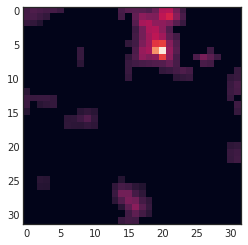

In [123]:
# example of village that isn't at center of image
visualize_viirs(89.877778, 22.840833)

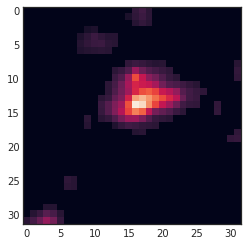

In [124]:
# last week's example image
visualize_viirs(90.1959352984, 22.6341331408)

In [240]:
diameter = 5
for i, idx in enumerate(bangladesh_2015.index):
  lat = bangladesh_2015["lat"][idx]
  lng = bangladesh_2015["long"][idx]
  if np.isnan(lat) or np.isnan(lng):
    print("Cannot locate row {}".format(idx))
    continue
  x, y = viirs_props.lonlat2colrow(lng, lat)
  patch = viirs_tif.ReadAsArray(x - diameter // 2, y - diameter // 2, diameter, diameter)
  if patch is None:
    print("No entry for row {}".format(idx))
  else:
    viirs_night_intensities["bangladesh"][i] = np.max(patch)

Cannot locate row 1659
Cannot locate row 2087
No entry for row 2433
No entry for row 5062
No entry for row 5327
No entry for row 5369
No entry for row 5416
No entry for row 5429


In [241]:
district_to_idx = dict(zip(set(bangladesh_grouped.index), range(len(bangladesh_grouped.index))))

In [242]:
for i, idx in enumerate(bangladesh_2015.index):
  district = bangladesh_2015["District"][i]
  viirs_night_intensities["bangladesh_grouped"][district_to_idx[district]] += viirs_night_intensities["bangladesh"][i]

In [243]:
df_viirs = pd.concat([pd.Series(viirs_night_intensities["bangladesh"], name="viirs"), 
                      bangladesh_2015["totexp_m"],
                      bangladesh_2015["a01"]], axis=1)
df_viirs_filt = df_viirs[df_viirs["totexp_m"] > 0]

In [244]:
df_viirs = pd.concat([pd.Series(viirs_night_intensities["bangladesh_grouped"], name="viirs"), 
                      bangladesh_grouped.reset_index(drop=True)], axis=1)
df_viirs_filt = df_viirs[df_viirs["totexp_m"] > 0]

In [245]:
# df_viirs = pd.concat([pd.Series(viirs_night_intensities["india"], name="viirs"), 
#                       india_sampled["secc_cons_per_hh"].reset_index(drop=True),
#                       india_sampled["id"].reset_index(drop=True)], axis=1)
# df_viirs_filt = df_viirs[df_viirs["secc_cons_per_hh"] > 0]
# df_viirs_filt = df_viirs_filt.set_index("id")

In [246]:
np.corrcoef(np.log(df_viirs_filt["viirs"] + 1), np.log(df_viirs_filt["totexp_m"] + 1))

array([[ 1.        ,  0.28127978],
       [ 0.28127978,  1.        ]])

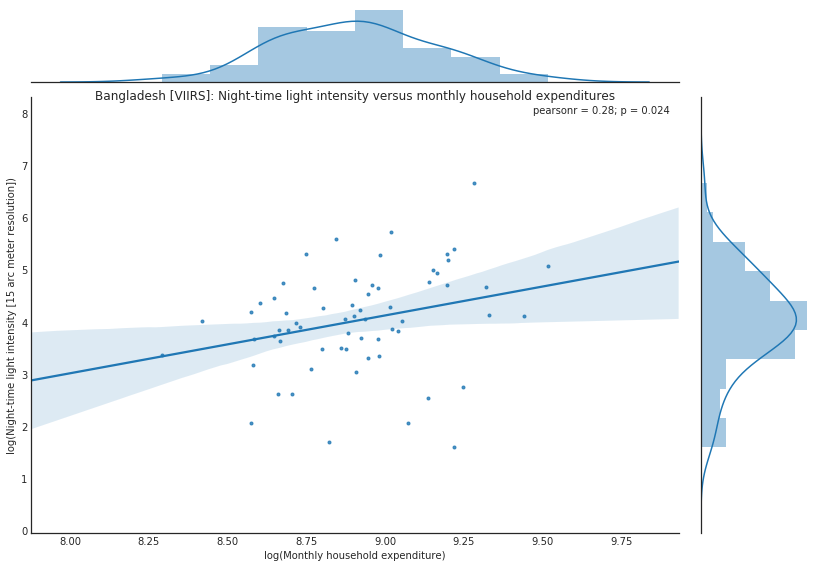

In [247]:
fig = sns.jointplot(np.log(df_viirs_filt["totexp_m"]), np.log(df_viirs_filt["viirs"] + 1), 
                    size=8, marker=".", kind="reg")
fig.fig.set_size_inches((12, 8))
fig.ax_joint.set(ylabel="log(Night-time light intensity [15 arc meter resolution])",
                 xlabel="log(Monthly household expenditure)")
fig.ax_joint.set_title("Bangladesh [VIIRS]: Night-time light intensity versus monthly household expenditures", y=0.98);

In [146]:
# fig = sns.jointplot(np.log(df_viirs_filt["secc_cons_per_hh"]), np.log(df_viirs_filt["viirs"] + 1), 
#                     size=8, marker=".")
# fig.fig.set_size_inches((12, 8))
# fig.ax_joint.set(ylabel="log(Night-time light intensity [15 arc meter resolution])",
#                  xlabel="log(Monthly household expenditure)")
# fig.ax_joint.set_title("India [VIIRS]: Night-time light intensity versus monthly household expenditures", y=0.98);

**DMSP dataset**

Resolution: 30 arc-seconds.

Date: 2013

In [148]:
lights_tif = "../data/bucket/F182013.v4c_web.stable_lights.avg_vis.tif"

In [149]:
dmsp_tif = gdal.Open(lights_tif)

In [150]:
dmsp_props = GeoProps()
dmsp_props.import_geogdal(dmsp_tif)

In [248]:
dmsp_night_intensities = {
  "bangladesh": np.zeros(len(bangladesh_2015)),
  "bangladesh_grouped": np.zeros(len(bangladesh_grouped))
}

In [249]:
diameter = 5
for i, idx in enumerate(bangladesh_2015.index):
  lat = bangladesh_2015["lat"][idx]
  lng = bangladesh_2015["long"][idx]
  if np.isnan(lat) or np.isnan(lng):
    print("Cannot locate row {}".format(idx))
    continue
  x, y = dmsp_props.lonlat2colrow(lng, lat)
  patch = dmsp_tif.ReadAsArray(x - diameter // 2, y - diameter // 2, diameter, diameter)
  if patch is None:
    print("No entry for row {}".format(idx))
  else:
    dmsp_night_intensities["bangladesh"][i] = np.max(patch)

Cannot locate row 1659
Cannot locate row 2087


In [250]:
for i, idx in enumerate(bangladesh_2015.index):
  district = bangladesh_2015["District"][i]
  dmsp_night_intensities["bangladesh_grouped"][district_to_idx[district]] += dmsp_night_intensities["bangladesh"][i]

In [30]:
# df_dmsp = pd.concat([pd.Series(dmsp_night_intensities["india"], name="dmsp"), 
#                      india_sampled["secc_cons_per_hh"],
#                      india_sampled["id"]], axis=1)
# df_dmsp.set_index("id");

In [251]:
df_dmsp = pd.concat([pd.Series(dmsp_night_intensities["bangladesh_grouped"], name="dmsp"), 
                     bangladesh_grouped.reset_index(drop=True)], axis=1)
df_dmsp_filt = df_dmsp[df_dmsp["totexp_m"] > 0]

In [252]:
df_dmsp_filt["totexp_m"].corr(df_dmsp_filt["dmsp"])

0.34497723423385657

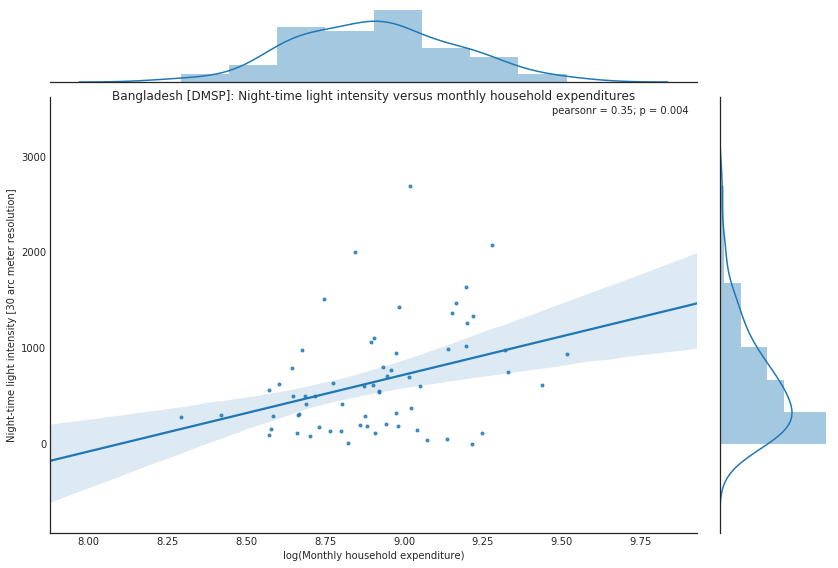

In [253]:
fig = sns.jointplot(np.log(df_dmsp_filt["totexp_m"]), df_dmsp_filt["dmsp"], 
                    kind="reg", size=8, marker=".")
fig.fig.set_size_inches((12, 8))
fig.ax_joint.set(ylabel="Night-time light intensity [30 arc meter resolution]",
                 xlabel="log(Monthly household expenditure)")
fig.ax_joint.set_title("Bangladesh [DMSP]: Night-time light intensity versus monthly household expenditures", y=0.98);

**Baseline -- HOG/Histograms/Night lights**

In [227]:
def load_tiff(hhid, country="bangladesh", prefix="s1", imgtype="vis", quiet=False):
  """
  hhid:    household index as float [pull from bangladesh_2015 csv]
  prefix:  either "s1" or "l8"
  imgtype: either "vis" or "multiband"
  """
  source_tiff = "../data/bucket/{}_median_{}_{}_500x500_{:.1f}.tif".format(prefix, country, imgtype, hhid)
  if not quiet:
    print("Loading {}...".format(source_tiff))
  gdal_tif = gdal.Open(source_tiff)
  return gdal_tif.ReadAsArray().astype("uint8")

In [228]:
def vis_tif(A):
  plt.imshow(A.transpose(1,2,0))

In [231]:
A = load_tiff(6170.0, prefix="l8", imgtype="vis")

Loading ../data/bucket/l8_median_bangladesh_vis_500x500_6170.0.tif...


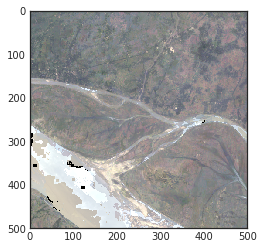

In [232]:
vis_tif(A)

In [233]:
A = load_tiff(6170.0, country="india", prefix="s1", imgtype="vis")

Loading ../data/bucket/s1_median_india_vis_500x500_6170.0.tif...


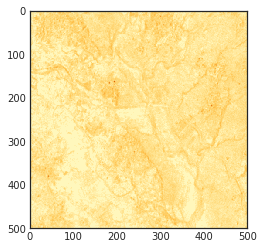

In [234]:
vis_tif(A)

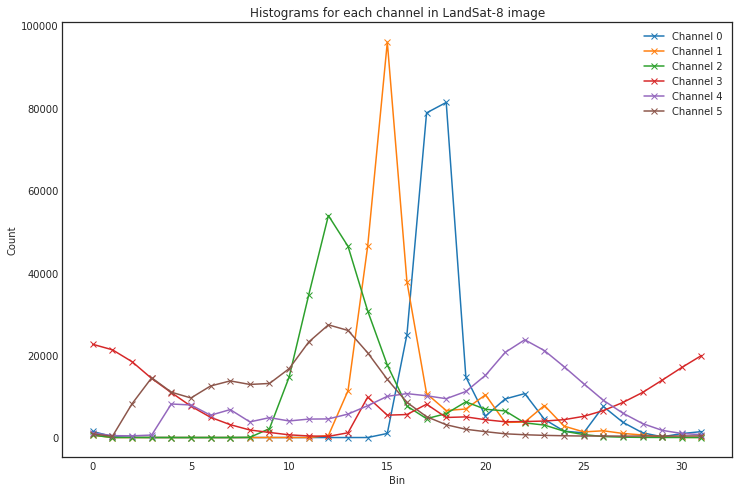

In [233]:
plt.figure(figsize=(12, 8))
for channel_idx in range(6):
  plt.plot(cv2.calcHist(A.astype("uint8"), 
                     channels=[channel_idx], 
                     mask=None, 
                     histSize=[32], 
                     ranges=[0, 256]), "x-", label="Channel {:d}".format(channel_idx))
plt.title("Histograms for each channel in LandSat-8 image")
plt.xlabel("Bin")
plt.ylabel("Count")
plt.legend();

In [219]:
A = load_tiff(6170.0, prefix="s1", imgtype="multiband")

Loading ../data/bucket/s1_median_bangladesh_multiband_500x500_6170.0.tif...


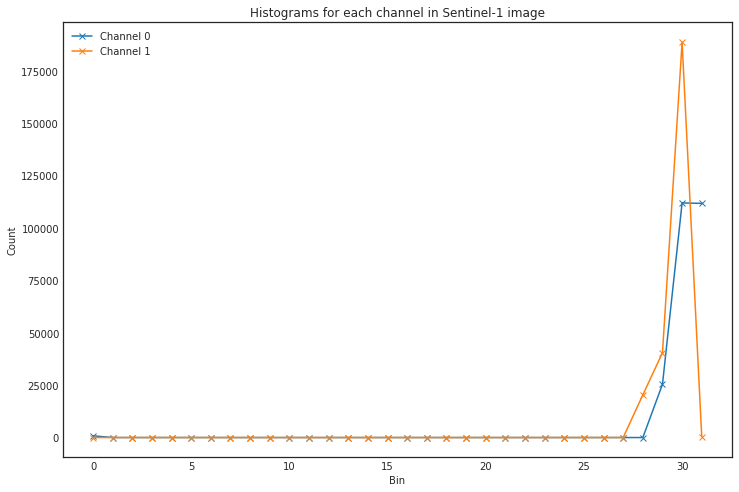

In [588]:
plt.figure(figsize=(12, 8))
for channel_idx in range(2):
  plt.plot(cv2.calcHist(A.astype("uint8"), 
                     channels=[channel_idx], 
                     mask=None, 
                     histSize=[32], 
                     ranges=[0, 256]), "x-", label="Channel {:d}".format(channel_idx))
plt.title("Histograms for each channel in Sentinel-1 image")
plt.xlabel("Bin")
plt.ylabel("Count")
plt.legend();

**Hog features [single-channel]**

In [578]:
A = load_tiff(6170.0, prefix="l8", imgtype="vis")

Loading ../data/bucket/l8_median_bangladesh_vis_500x500_6170.0.tif...


In [579]:
fd = hog(A[0], orientations=8, pixels_per_cell=(16, 16),
        cells_per_block=(1, 1), visualise=True)[0]

/usr/local/lib/python3.5/dist-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


In [580]:
fd, hog_image = hog(A[0], orientations=8, pixels_per_cell=(16, 16),
                    cells_per_block=(1, 1), visualise=True)

/usr/local/lib/python3.5/dist-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


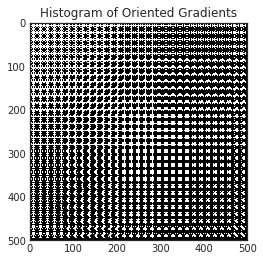

In [581]:
# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 0.02))

# ax2.axis('off')
plt.imshow(hog_image_rescaled, cmap=plt.cm.gray)
plt.title('Histogram of Oriented Gradients');

**Histogram of each channel [LandSat-8]**

Note that we use a resolution of 8 pixel values per histogram bin, for a total of 32 bins per image.

In [254]:
l8_channel_hists = [[] for _ in range(6)]
s1_channel_hists = [[] for _ in range(2)]

In [256]:
error_vect = np.zeros(len(bangladesh_2015))

In [99]:
# i, hhid = 0, 1

In [100]:
# SM = load_tiff(hhid, prefix="s1", country="india", imgtype="vis", quiet=True)

In [101]:
# for channel_idx in range(2):
#   hist = cv2.calcHist(SM.astype("uint8"), 
#                      channels=[channel_idx], 
#                      mask=None, 
#                      histSize=[32], 
#                      ranges=[0, 256])
#   s1_channel_hists[channel_idx].append(hist / np.sum(hist))

In [ ]:
for i, hhid in enumerate(bangladesh_2015["a01"]):
  if i % 100 == 0:
    print("{}/{} errors.".format(sum(error_vect), i))
  try:
    LM = load_tiff(hhid, prefix="l8", country="bangladesh", imgtype="multiband", quiet=True)
    SM = load_tiff(hhid, prefix="s1", country="bangladesh", imgtype="vis", quiet=True)
    for channel_idx in range(6):
      hist = cv2.calcHist(LM.astype("uint8"), 
                          channels=[channel_idx], 
                          mask=None, 
                          histSize=[32], 
                          ranges=[0, 256])
      l8_channel_hists[channel_idx].append(hist / np.sum(hist))
    for channel_idx in range(2):
      hist = cv2.calcHist(SM.astype("uint8"), 
                         channels=[channel_idx], 
                         mask=None, 
                         histSize=[32], 
                         ranges=[0, 256])
      s1_channel_hists[channel_idx].append(hist / np.sum(hist))
#     hogs.append(hog(SM[0], orientations=8, pixels_per_cell=(16, 16),
#                 cells_per_block=(1, 1), visualise=True)[0])
  except:
    error_vect[i] = 1

0.0/0 errors.
0.0/100 errors.
0.0/200 errors.
8.0/300 errors.
53.0/400 errors.
53.0/500 errors.
53.0/600 errors.
53.0/700 errors.
53.0/800 errors.
53.0/900 errors.
85.0/1000 errors.
104.0/1100 errors.
108.0/1200 errors.
128.0/1300 errors.
128.0/1400 errors.
128.0/1500 errors.
159.0/1600 errors.
160.0/1700 errors.
160.0/1800 errors.
160.0/1900 errors.
160.0/2000 errors.
194.0/2100 errors.
194.0/2200 errors.
194.0/2300 errors.
194.0/2400 errors.
196.0/2500 errors.
198.0/2600 errors.
243.0/2700 errors.
245.0/2800 errors.
292.0/2900 errors.
292.0/3000 errors.
310.0/3100 errors.
322.0/3200 errors.
326.0/3300 errors.
326.0/3400 errors.
339.0/3500 errors.
360.0/3600 errors.
361.0/3700 errors.


In [258]:
error_vect = pd.Series(error_vect)

In [259]:
np.sum(error_vect)

782.0

Construct $X$ and $Y$ data and partition into train/test/valid.

In [263]:
# viirs_night_intensities

In [264]:
# np.hstack(np.hstack(s1_channel_hists)).T[:2000].shape

In [265]:
# viirs_night_intensities["bangladesh"][:2000].shape

In [127]:
# X = np.c_[#np.hstack(np.hstack(l8_channel_hists)).T, 
#           np.hstack(np.hstack(s1_channel_hists)).T[:2000], 
# #           hogs, 
#           viirs_night_intensities["india"][:2000],
#           dmsp_night_intensities["india"][:2000]]

In [300]:
viirs_night_intensities["bangladesh_ungrouped"] = np.zeros(len(bangladesh_2015))

In [303]:
viirs_night_intensities["bangladesh_ungrouped"] = bangladesh_2015["District"].apply(lambda z: viirs_night_intensities["bangladesh_grouped"][district_to_idx[z]])

In [411]:
dmsp_night_intensities["bangladesh_grouped"]

array([  379.,     0.,   133.,   603.,     5.,   540.,  1019.,   695.,
         752.,   174.,  2684.,    46.,  1427.,   977.,  1107.,   615.,
         155.,   937.,   617.,  1470.,   207.,   627.,   945.,   552.,
         638.,    41.,  1065.,   149.,   299.,   503.,   290.,   291.,
         600.,   561.,  1365.,   197.,  1258.,  2076.,  1999.,  1508.,
         182.,  1336.,   987.,   139.,    88.,   117.,   420.,   707.,
         496.,    83.,   109.,   319.,   300.,   311.,   114.,   791.,
         805.,   420.,   499.,   187.,   984.,  1639.,   772.,   276.])

In [307]:
dmsp_night_intensities["bangladesh_ungrouped"] = bangladesh_2015["District"].apply(lambda z: dmsp_night_intensities["bangladesh_grouped"][district_to_idx[z]])

In [475]:
X = np.c_[np.hstack(np.hstack(l8_channel_hists)).T, 
          np.hstack(np.hstack(s1_channel_hists)).T, 
          np.log(viirs_night_intensities["bangladesh_ungrouped"][error_vect == False]),
          dmsp_night_intensities["bangladesh_ungrouped"][error_vect == False],
#           hogs, 
          viirs_night_intensities["bangladesh"][error_vect == False],
          dmsp_night_intensities["bangladesh"][error_vect == False]
         ]

In [476]:
X = pd.DataFrame(X)

In [477]:
y = bangladesh_2015[error_vect == False]

In [479]:
X = X.assign(a01=pd.Series(y["a01"]).values)

In [480]:
X = X[y.reset_index()["totexp_m"] > 0]
y = y[y["totexp_m"] > 0]

In [560]:
# np.save("../data/bangladesh_baseline_X.npy", X)
# np.save("../data/bangladesh_baseline_y.npy", y)

In [563]:
X = np.load("../data/bangladesh_baseline_X.npy")
Y = np.load("../data/bangladesh_baseline_y.npy")

In [564]:
X.shape, y.shape

((6280, 261), (6280, 6))

In [482]:
X_train = X[np.in1d(X["a01"], bangladesh_2015_train["a01"])]
y_train = y[np.in1d(y["a01"], bangladesh_2015_train["a01"])]

In [483]:
X_valid = X[np.in1d(X["a01"], bangladesh_2015_valid["a01"])]
y_valid = y[np.in1d(y["a01"], bangladesh_2015_valid["a01"])]

In [484]:
y_train = y_train["totexp_m"]
y_valid = y_valid["totexp_m"]

In [485]:
X_train.shape, y_train.shape

((4624, 261), (4624,))

In [486]:
X_valid.shape, y_valid.shape

((1057, 261), (1057,))

Ridge regression: hyperparameter search.

In [487]:
# X_train = X[:1500]
# X_valid = X[1500:]

In [488]:
# y_train = y["totexp_m"][:1500]
# y_valid = y["secc_cons_per_hh"][1500:]

In [545]:
lm = Ridge(alpha=2, normalize=True)

In [529]:
lm.fit(X_train, np.log(y_train))

Ridge(alpha=1.0000000000000001e-05, copy_X=True, fit_intercept=True,
   max_iter=None, normalize=True, random_state=None, solver='auto',
   tol=0.001)

In [491]:
lm.score(X_valid, np.log(y_valid))

0.058795133386723826

In [546]:
train_scores = []

In [547]:
scores = []

In [548]:
for alpha in np.logspace(-5, 5, num=20):
  lm = Ridge(alpha=alpha, normalize=True)
  lm.fit(X_train, np.log(y_train))
  y_pred = np.exp(lm.predict(X_train))
  train_scores.append(np.corrcoef(y_pred, y_train)[0, 1] ** 2)
  y_pred = np.exp(lm.predict(X_valid))
  score = np.corrcoef(y_pred, y_valid)[0, 1] ** 2
  print("alpha:", alpha, "\tscore:", score)
  scores.append(score)

alpha: 1e-05 	score: 0.056585419476
alpha: 3.35981828628e-05 	score: 0.0576084998619
alpha: 0.000112883789168 	score: 0.0596687065779
alpha: 0.000379269019073 	score: 0.0633441070845
alpha: 0.0012742749857 	score: 0.0692765653159
alpha: 0.00428133239872 	score: 0.077549847171
alpha: 0.0143844988829 	score: 0.0852731296909
alpha: 0.0483293023857 	score: 0.0907345883169
alpha: 0.162377673919 	score: 0.0955195170744
alpha: 0.545559478117 	score: 0.0999318073122
alpha: 1.83298071083 	score: 0.102439531243
alpha: 6.15848211066 	score: 0.103398693398
alpha: 20.6913808111 	score: 0.100298480875
alpha: 69.5192796178 	score: 0.0927120466249
alpha: 233.572146909 	score: 0.0869727765279
alpha: 784.759970351 	score: 0.0845494298757
alpha: 2636.65089873 	score: 0.083741371514
alpha: 8858.6679041 	score: 0.0834923543467
alpha: 29763.5144163 	score: 0.0834174604012
alpha: 100000.0 	score: 0.0833950997946


Text(0.5,0,'$\\alpha$ [log scale]')

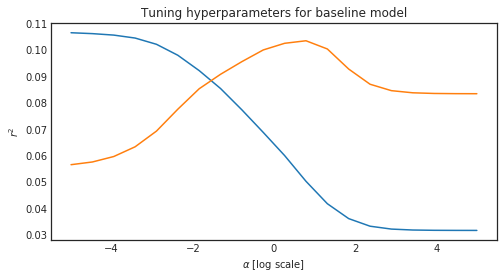

In [552]:
plt.figure(figsize=(8, 4))
plt.plot(np.linspace(-5, 5, num=20), train_scores, label="Train")
plt.plot(np.linspace(-5, 5, num=20), scores, label="Valid")
plt.title("Tuning hyperparameters for baseline model")
plt.ylabel("$r^2$")
plt.xlabel("$\\alpha$ [log scale]")

In [495]:
lm = Ridge(alpha=1.83298071083, normalize=True)
lm.fit(X_train, np.log(y_train))

Ridge(alpha=1.83298071083, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=True, random_state=None, solver='auto', tol=0.001)

In [496]:
lm.score(X_valid, np.log(y_valid))

0.059170220610139761

In [497]:
y_pred = np.exp(lm.predict(X_valid))

In [498]:
np.sqrt(np.mean(np.square(y_pred - y_valid)))

4536.355578739156

In [502]:
np.corrcoef(y_valid, y_pred)

array([[ 1.        ,  0.32006176],
       [ 0.32006176,  1.        ]])

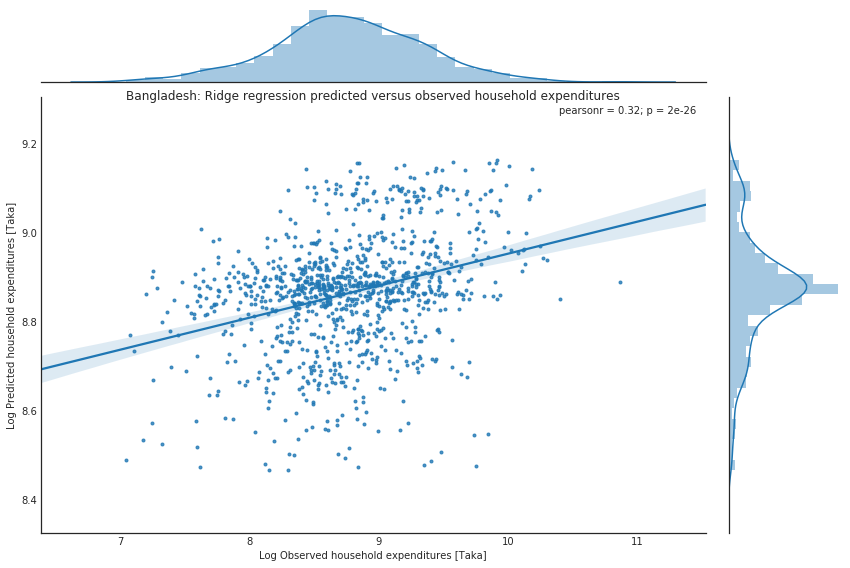

In [505]:
fig = sns.jointplot(np.log(y_valid[np.logical_and(y_valid > 0, y_pred > 0)]), 
                    np.log(y_pred[np.logical_and(y_valid > 0, y_pred > 0)]), 
                    kind="reg", size=8, marker=".")
fig.fig.set_size_inches((12, 8))
fig.ax_joint.set(ylabel="Log Predicted household expenditures [Taka]",
                 xlabel="Log Observed household expenditures [Taka]")
fig.ax_joint.set_title("Bangladesh: Ridge regression predicted versus observed household expenditures", y=0.98);

Lasso regression.

In [394]:
lm = Lasso(alpha=1200.0)

In [395]:
lm.fit(X_train, y_train)

/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Lasso(alpha=1200.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [396]:
lm.score(X_train, y_train)

0.10488938994692287

In [397]:
lm.score(X_valid, y_valid)

0.028151352015512776

In [399]:
y_pred = lm.predict(X_valid)

In [400]:
np.sqrt(np.mean(np.square(y_pred - y_valid)))

4957.7729108895837

Random forest regression.

In [558]:
rf = RandomForestRegressor(criterion="mse", max_depth=12, n_estimators=50, n_jobs=4)

In [559]:
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=12,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=4,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [180]:
rf.score(X_train, y_train)

0.8013085528083016

In [181]:
rf.score(X_valid, y_valid)

0.077254831443688943

In [448]:
y_pred = rf.predict(X_valid)

In [449]:
np.sqrt(np.mean(np.square(y_pred - y_valid)))

5182.123913879178